# Part 1: Create database set
By inputting a target gene, a nested dictionary will be created, with each key being the name of a cancer and each value being a dictionary containing the genomic, proteomic, transcriptomic, and phosphoproteomic data. In other words, the dictionary will be:

{
    cancer : {   
    
            "gen" : <cancer's genomic data>,
            "prot" : <cancer's proteomic data>,
            "trans": <cancer's transcriptomic data>,
            "phos": <cancer's phosphoproteomic data>
        }
    ... for each cancer
}

In [1]:
import cptac
import cptac.pancan as pc
import numpy as np
import cptac.utils as ut
import plot_utils as plt_ut
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset_names = pc.list_datasets(False)
dataset_names  = dataset_names.split('\n')
dataset_names

['PancanBrca',
 'PancanCcrcc',
 'PancanCoad',
 'PancanGbm',
 'PancanHnscc',
 'PancanLscc',
 'PancanLuad',
 'PancanOv',
 'PancanUcec',
 'PancanPdac']

In [4]:
target_gene = "TP53"

In [5]:
# List of pathways to select for the trans analysis
paths = ut.get_pathways_with_proteins(proteins = target_gene, database = 'wikipathways')
paths

,id,pathway
0,TP53,MAPK Signaling Pathway
1,TP53,DNA Damage Response
2,TP53,Wnt Signaling Pathway and Pluripotency
3,TP53,Pathways Affected in Adenoid Cystic Carcinoma
4,TP53,Retinoblastoma Gene in Cancer
5,TP53,Mammary gland development pathway - Involution...
6,TP53,miRNA regulation of p53 pathway in prostate ca...
7,TP53,miRNA Regulation of DNA Damage Response
8,TP53,Ultraconserved region 339 modulation of tumor ...
9,TP53,Gastric Cancer Network 2


In [6]:
# Indicate the NUMERICAL INDICES of the pathways of interest
path_indices=[0,1,2,10,18]

In [7]:
datasets = {}
for name in dataset_names:
    exec(f"cancer = pc.{name}(no_internet = True)")  
    genotype_data = cancer.get_genotype_all_vars(target_gene, omics_source = "washu")
    
    proteomic_data = cancer.get_proteomics(source = 'umich')
    proteomic_data = proteomic_data.droplevel("Database_ID", axis = 1)
    
    phospho_data = cancer.get_phosphoproteomics(source = 'umich')
    phospho_data = phospho_data.droplevel("Database_ID", axis = 1).droplevel("Peptide", axis = 1)
    
    transcript_data = cancer.get_transcriptomics(source = "washu")
    transcript_data = transcript_data.droplevel("Database_ID", axis = 1)
    
    datasets[name[6:]] = {
                        "gen" : genotype_data,
                        "prot": proteomic_data,
                        "trans": transcript_data,
                        "phos" : phospho_data
                         }    
    print(f"Loaded {name}...")

Loaded PancanBrca...                
Loaded PancanCcrcc...                    
Loaded PancanCoad...                
Loaded PancanGbm...                   
Loaded PancanHnscc...                    
Loaded PancanLscc...                    
Loaded PancanLuad...                    
Loaded PancanOv...                 
Loaded PancanUcec...                    
Loaded PancanPdac...                    


In [8]:
#DELETE THIS CELL
#I use this to let me know when the data has finished loading haha
import webbrowser
webbrowser.open("https://www.youtube.com/watch?v=dQw4w9WgXcQ")

True

# Part 2: Select mutations
Determine which cancers have mutation types with rates above 20%.

To facilitate that, the mutation types from the get_genotype_all_vars must be grouped into functional types.


In [9]:
mutation_types = ["Deletion", "Amplification", "Truncation", "Indel", "Missense"]

In [10]:
# Grouping the mutation types for each cancer
for name, dataset in datasets.items():
    genotypes = dataset["gen"]
    genotypes.replace(["Nonsense_Mutation", "Frame_Shift_Ins", "Frame_Shift_Del"], "Truncation", inplace = True)
    genotypes.replace(["In_Frame_Del", "In_Frame_Ins"], "Indel", inplace = True)
    genotypes.replace(["Missense_Mutation", "Wildtype_Tumor"], ["Missense", "Wildtype"], inplace = True)
    genotypes = genotypes.loc[~genotypes["Mutation"].isin(["Intron","Silent"])]
    datasets[name]["gen"] = genotypes

In [11]:
# Create a bargraph displaying the mutation types

In [12]:
# Determine which cancers have mutation rates over 20%
variants_to_analyze = {}
for name, dataset in datasets.items():
    mut_type_freq = dataset["gen"]["Mutation"].value_counts() / len(dataset["gen"])
    
    mut_type_freq = mut_type_freq.loc[mut_type_freq >= 0.2]
    variants_to_analyze[name] = set(mut_type_freq.index.tolist())
    variants_to_analyze[name].discard("Wildtype")
print(str(variants_to_analyze))

{'Brca': {'Deletion'}, 'Ccrcc': set(), 'Coad': {'Deletion'}, 'Gbm': set(), 'Hnscc': {'Missense', 'Truncation'}, 'Lscc': {'Deletion', 'Missense'}, 'Luad': {'Deletion', 'Missense'}, 'Ov': {'Deletion', 'Missense'}, 'Ucec': set(), 'Pdac': {'Missense', 'Deletion'}}


In [13]:
# plt.figure1_plot_mutations(datasets.values(), list(datasets.keys()), save_to_path = "Test_Figure.png")

# Part 3: Cis effects
Determines which genes that, given a mutation, will change the expression in their own proteomics, transcriptomics, or phosphoproteomics.This analysis is repeated for every cancer, and every mutation type.

Writes out a file containing the infomation for each mutation and cancer, and creates boxplot summarizing the data

In [14]:
from scipy.stats import ttest_ind
omics_key = {"prot":"proteomics", "trans":"transcriptomics","phos":"phosphoproteomics"}

In [50]:
'''
Parameters
pval_symbol: String. The symbol associated with the significance of the pvalue (NS, *, **, or ***)
x1, x2: Float. x coordinates for the start and end of the annotation line.
line_start: Float. y coordinate for the horizontal line (Default = .05).
line_height: Float. The height of the vertical lines at the start and end of the horizontal line (Default = .05).

Returns a formated annotation line showing the significance symbol of each pvalue.
'''
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

In [51]:
def generate_cis_plot(boxplot_data, omics_type, pval_df):
    plt.rcParams['figure.figsize'] = (15,10) # size of plot
#     if len(gene_list) > 15:
#         plt.rcParams['figure.figsize']=(20,10)
    sns.set(font_scale = 1.2, style = "white")

    for site in boxplot_data["site"].unique():
        mutations = sorted(boxplot_data["Mutation"].unique(), reverse = True)
        boxplot = sns.boxplot(x = "cancer_type", y = site, hue = "Mutation", showfliers = False, 
                              data = boxplot_data[boxplot_data["site"] == site], hue_order = mutations)
        boxplot = sns.stripplot(x = "cancer_type", y = site, hue = "Mutation", jitter = True, hue_order = mutations,
                               color = ".3", dodge = True, data = boxplot_data[boxplot_data["site"] == site])
        gene_site = site if site == target_gene else target_gene+'.'+site
        boxplot.set(xlabel = "", ylabel = f"{gene_site}_{omics_key[omics_type]}")
        boxplot.set(title = f"Pancan Analysis of {gene_site} {omics_key[omics_type].capitalize()} Mutations")
#         if len(gene_list) > 15:
#             boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation=50)
        
        num = len(boxplot_data["Mutation"].unique())
        handles, labels = boxplot.get_legend_handles_labels()
        legend = plt.legend(handles[0:num], labels[0:num], loc = "lower right")
        
        ## CREATE PVAL ANNOTATIONS
        symbols = {}
        start = -0.3
        cancer_list = boxplot.get_xticklabels() # get a list of cancer types actually plotted 
        first_mutation = mutations[1]
        bottom,top = plt.ylim()
        annot_size = top + 0.5
        annot_scale = (top - bottom) * 0.05 # sets annotation height between mutations based on y-axis scale
        for cancer in cancer_list:
            cancer = cancer.get_text()
            mutation_list = sorted(boxplot_data.loc[boxplot_data["cancer_type"] == cancer]["Mutation"].unique().tolist(),
                                   reverse = True)
            mutation_list.remove("Wildtype")
            offset = 0.4
            annot_offset = annot_scale
            for mutation in mutation_list:
                pval = pval_df.loc[(pval_df["Cancer"] == cancer)&(pval_df["Mutation"] == mutation)&
                                   (pval_df["Site"] == site)]['P_Value']
                if pval.tolist():
                    pval = pval.tolist()[0]
                    if pval  <= 0.001:
                         symbols[cancer] = '***'
                    elif pval  <= 0.01:
                        symbols[cancer] = '**'  
                    elif pval <= 0.05:
                        symbols[cancer] = '*'
                    else:
                        symbols[cancer] = 'ns'
                    if mutation == first_mutation:
                        format_pval_annotation(symbols[cancer], start, start + 0.2, annot_size)
                    else:
                        format_pval_annotation(symbols[cancer], start, start + offset, annot_size + annot_offset)
                        offset += 0.2
                        annot_offset += annot_scale
            start += 1
        
        plt.show()
        plt.clf()
        plt.close()
            
#         fig = boxplot.get_figure()
#         fig.savefig(f"Cis_Effect_output/Test_{gene_site}_{omics_key[omics_type]}.png")
#         fig.clf()

In [52]:
# Create a function that will analyze the protein cis effects for a given mutation type
def analyze_cis_mutation(omics_type, write_out = True, output_boxplot = True):
    """Analyzes the cis effects for a given mutation type across all cancers.
    
    Parameters:
    omics_type (str): The omics to analyze. Possible values are in list ["prot", "trans", "phos"]
    write_out (bool, optional): Whether to write out the data to a separate file.
    
    Returns the output of scipy.ttest_ind() between "Wildtype" and mutation_type tumors. If analyzing phosphoproteomics, returns a list of such outputs
    """
    if write_out:
        # Clears the target file
        file_name = f"Cis_Effect_output/{omics_key[omics_type].capitalize()}_Analysis_cis.txt"
        with open(file_name, 'w') as out_file: pass
                
    result = []
    pval_dict = {'Cancer':[], 'Mutation':[], 'Site':[], 'P_Value':[]}
    boxplot_data = []
    for cancer_type, dataset in datasets.items():
        if write_out:
            with open(file_name, 'a') as out_file:
                out_file.write(cancer_type.upper()+'\n')
            
        for mutation_type in mutation_types:
            ## PREPARE DATA ##
            if mutation_type not in variants_to_analyze[cancer_type]: 
                continue
            print(f"{cancer_type} {mutation_type}s") #debug temp
            genotype_and_omic = pd.merge(dataset["gen"]["Mutation"], dataset[omics_type][target_gene], left_index = True,
                                         right_index = True)
            genotype_and_omic = genotype_and_omic.loc[genotype_and_omic["Mutation"].isin(["Wildtype", mutation_type])]
                            
            for site in genotype_and_omic.drop("Mutation", axis = 1).columns:
                ## ANALYZE P-VALUES ##
                try:
                    pval = ut.wrap_ttest(genotype_and_omic, label_column="Mutation", comparison_columns=[site],
                                         correction_method = "fdr_bh", return_all=True).iloc[0,1]
                except:
                    continue
                pval_dict['Cancer'].append(cancer_type)
                pval_dict['Mutation'].append(mutation_type)
                pval_dict['Site'].append(site)
                pval_dict['P_Value'].append(pval)
                
                result.append ({
                    "omics_type":omics_type,
                    "site":site,
                    "mutation_type":mutation_type,
                    "cancer_type":cancer_type,
                    "pval":pval
                })
                    
                ## GATHER DATA FOR BOXPLOT ##
                if output_boxplot:
                    new_data = genotype_and_omic[(genotype_and_omic["Mutation"] == mutation_type)|
                                                (genotype_and_omic["Mutation"] == "Wildtype")]
                    new_data["site"], new_data["cancer_type"] = site, cancer_type
                    boxplot_data.append(pd.DataFrame(new_data))
                
                ## WRITE OUT RESULT ##
                if write_out:
                    with open(file_name, 'a') as out_file: 
                        out_file.write(f"   {mutation_type} p-val: {pval}\n")
    
    ## CREATE BOXPLOT ##
    if output_boxplot:
        pval_df = pd.DataFrame(pval_dict)
        boxplot_data = pd.concat(boxplot_data)
        generate_cis_plot(boxplot_data, omics_type, pval_df) 
        
    result = pd.DataFrame(result)
    return result

Brca Deletions
Coad Deletions
Hnscc Truncations
Hnscc Missenses
Lscc Deletions
Lscc Missenses
Luad Deletions
Luad Missenses
Ov Deletions
Ov Missenses
Pdac Deletions
Pdac Missenses


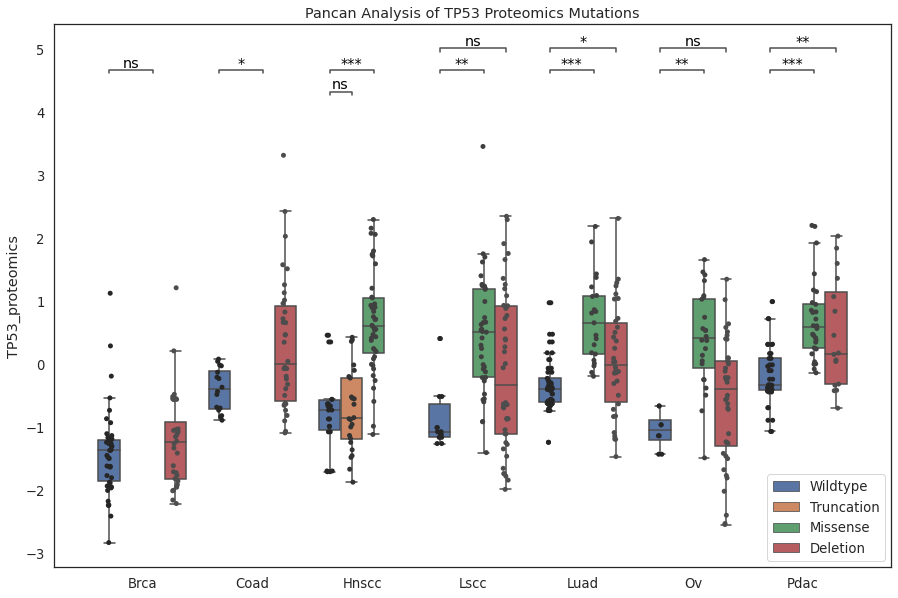

Brca Deletions
Coad Deletions
Hnscc Truncations
Hnscc Missenses
Lscc Deletions
Lscc Missenses
Luad Deletions
Luad Missenses
Ov Deletions
Ov Missenses
Pdac Deletions
Pdac Missenses


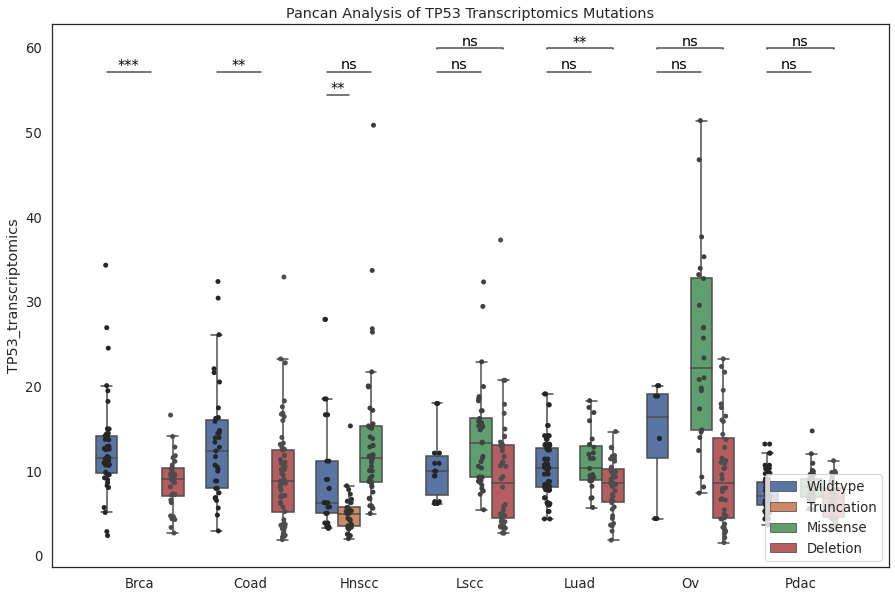

Brca Deletions
Coad Deletions
Hnscc Truncations
Hnscc Missenses
Lscc Deletions
Lscc Missenses
Luad Deletions
Luad Missenses
Ov Deletions
Ov Missenses
Pdac Deletions
Pdac Missenses


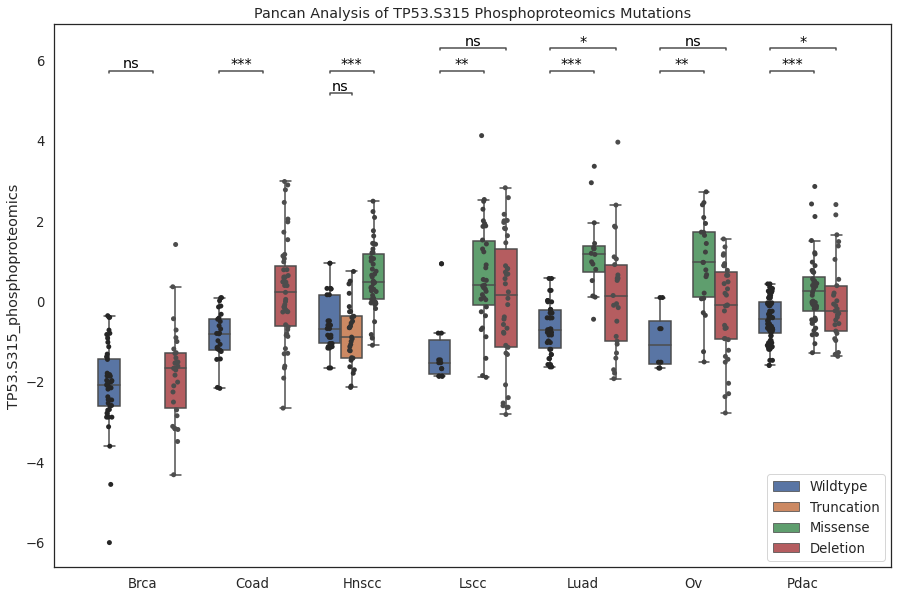

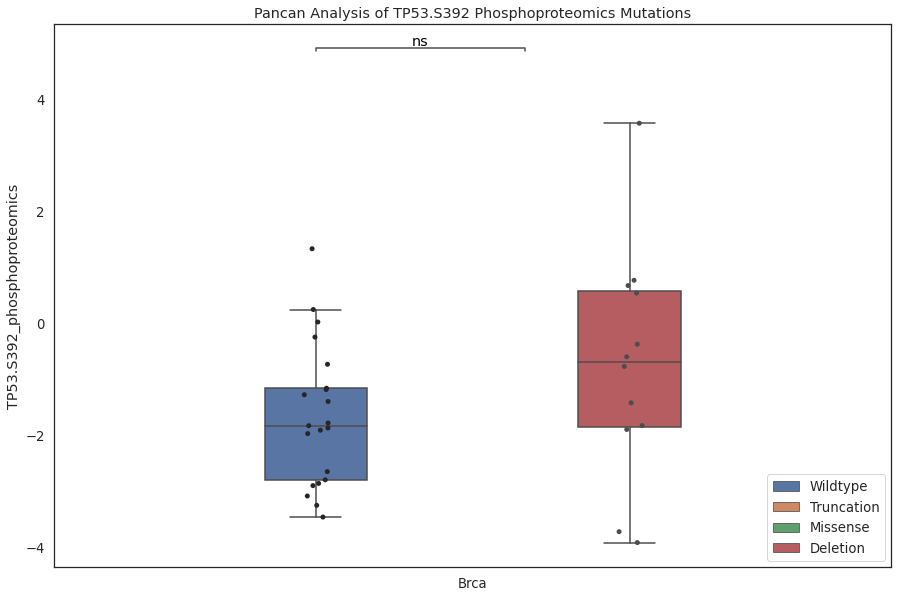

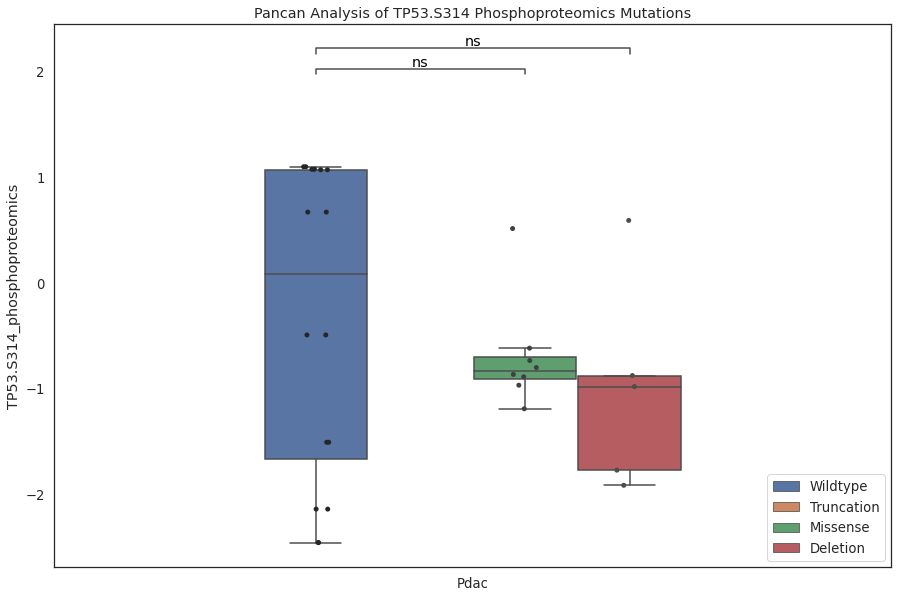

,omics_type,site,mutation_type,cancer_type,pval
0,prot,TP53,Deletion,Brca,2.621251e-01
1,prot,TP53,Deletion,Coad,1.191041e-02
2,prot,TP53,Truncation,Hnscc,9.801438e-01
3,prot,TP53,Missense,Hnscc,2.176079e-06
4,prot,TP53,Deletion,Lscc,1.477360e-01
5,prot,TP53,Missense,Lscc,1.423369e-03
6,prot,TP53,Deletion,Luad,2.707681e-02
7,prot,TP53,Missense,Luad,2.656354e-08
8,prot,TP53,Deletion,Ov,3.607840e-01
9,prot,TP53,Missense,Ov,1.134810e-03


In [53]:
cis_effects = pd.concat([analyze_cis_mutation(omics_type) for omics_type in ["prot", "trans", "phos"]])
cis_effects

# Part 4: Trans Effects
Determines which genes that, given a mutation, will change the expression in another protein's proteomics, transcriptomics, or phosphoproteomics.This analysis is repeated for every cancer, and every mutation type.

To reduce the computational intensity and the corrections needed, the scope will be restricted to genes that share specific pathways with the target gene. These pathways are hypothesized to be significant in the gene's function, and **must be specificed beforehand**, either at the beginning of this notebook or in the following cells.

The analysis will then be repeated for all genes in the dataset. As the number of comparisons is greater, the correction applied will be more substantial.

Writes out a file containing the infomation for each mutation and cancer, and creates boxplot summarizing the data

In [19]:
if path_indices == []:
    print(paths)
    path_indices = []

In [20]:
interacting_proteins = ut.get_proteins_in_pathways(paths["pathway"].loc[path_indices], database = 'wikipathways')
interacting_proteins = set(interacting_proteins["member"])

# genes_measured = [gene for dataset in datasets.values() for gene in dataset["prot"].columns]
genes_measured = set([gene for gene in dataset["prot"].columns for dataset in datasets.values()])
genes_to_analyze = sorted([protein for protein in interacting_proteins if protein in genes_measured])
no_analysis = sorted([protein for protein in interacting_proteins if protein not in genes_measured])# debug temp

if target_gene in genes_to_analyze:
    genes_to_analyze.remove(target_gene)
print(f"Interacting genes: {len(interacting_proteins)}")
print(f"Not measured in cptac: {len(no_analysis)}") #debug temp
print(f"Genes to analyze: {len(genes_to_analyze)}")

Interacting genes: 443
Not measured in cptac: 160
Genes to analyze: 282


In [21]:
# Create a function that will analyze the protein cis effects for a given mutation type
def analyze_trans_mutation(omics_type, genes_to_analyze = None, write_out = True, output_boxplot = True, write_insignificant=False):
    """Analyzes the cis effects for a given mutation type across all cancers.
    
    Parameters:
    omics_type (str): The omics to analyze. Possible values are in list ["prot", "trans", "phos"]
    write_out (bool, default=True): Whether to write out the data to a separate file.
    output_boxplot (bool, default=True): Outputs the data as a boxplot given by the generate_trans_plot function
    write_insignificant (bool, default=True): Returns data only when the p-value <= 0.05. If write_out, it only writes out the data under that condition.
    
    Returns the output of scipy.ttest_ind() between "Wildtype" and mutation_type tumors. If analyzing phosphoproteomics, returns a list of such outputs
    """
    if write_out:
        # Clears the target file
        file_name = f"Trans_Effect_output/{omics_key[omics_type].capitalize()}_Analysis_trans.txt"
        with open(file_name, 'w') as out_file: pass
                
    for cancer_type, dataset in datasets.items():
        ## PREPARE DATA ##
        genotype_and_omic = dataset[omics_type].copy()
        if genes_to_analyze is not None:
            genotype_and_omic = genotype_and_omic.filter(regex='|'.join(genes_to_analyze), axis=1)
        else:
            genotype_and_omic.drop(target_gene, axis = 1, inplace=True)
        if isinstance(genotype_and_omic.columns, pd.MultiIndex):
            genotype_and_omic.columns = ['_'.join(col) for col in genotype_and_omic.columns.values]
        genotype_and_omic["Mutation"] = dataset["gen"]["Mutation"].copy()
        genotype_and_omic = genotype_and_omic.loc[:,~genotype_and_omic.columns.duplicated()]
        
        for mutation_type in mutation_types:
            if mutation_type not in variants_to_analyze[cancer_type]: 
                continue
            if write_out:
                with open(file_name, 'a') as out_file:
                    out_file.write(f"\n\n{cancer_type.upper()} {mutation_type.upper()}: ")
            print(f"{cancer_type} {mutation_type}s") #debug temp

            target_mut_data = genotype_and_omic.loc[genotype_and_omic["Mutation"].isin(["Wildtype", mutation_type])]
   
            ## ANALYZE P-VALUES ##
            mutation_analysis = ut.wrap_ttest(target_mut_data, label_column="Mutation",
                                correction_method = "fdr_bh", return_all=True)#.iloc[0,1]
            mutation_analysis.rename({'Comparison':'Site'}, axis = 1, inplace = True)
            mutation_analysis['Cancer'], mutation_analysis['Mutation'] = cancer_type, mutation_type
            
            try:
                result = pd.concat([result, mutation_analysis])
            except NameError:
                result = mutation_analysis

            ## GATHER DATA FOR BOXPLOT ##
            if output_boxplot:
                new_data = genotype_and_omic[(genotype_and_omic["Mutation"] == mutation_type)|
                                            (genotype_and_omic["Mutation"] == "Wildtype")]
                new_data["cancer_type"] = cancer_type
                try:
                    boxplot_data = pd.concat([boxplot_data, new_data], axis=0)
                except NameError:
                    boxplot_data = new_data

            ## WRITE OUT RESULT ##
            if write_out:
                with open(file_name, 'a') as out_file:
                    out_file.write(f"{len(result.loc[result['P_Value'] <= 0.05])} Entries\n")
                    if not write_insignificant:
                        result = result.loc[result['P_Value'] <= 0.05]
                    
                    for row in result.iterrows():
                        data = row[1]
                        out_file.write(f"   {data['Site']}:".ljust(15) + f"{data['P_Value']}\n")
                        
#                     out_file.write("\n\n\n***SIGNIFICANT***\n")
#                     result = result.loc[result['P_Value'] <= 0.05]
#                     for row in result.iterrows():
#                         data = row[1]
#                         out_file.write(f"   {data['Cancer'].upper()} {data['Mutation']}: {data['Site']} : {data['P_Value']}\n")
    
    ## CREATE BOXPLOT ##
#     if output_boxplot:
#         pval_df = pd.DataFrame(pval_dict)
#         generate_cis_plot(boxplot_data, omics_type, pval_df) 
        
    return result

In [43]:
trans_effects = None
for omics_type in ["prot", "trans", "phos"]:
    print(omics_type.upper() + ':')
    data = analyze_trans_mutation(omics_type, genes_to_analyze=genes_to_analyze)
    data["Omics_Type"] = omics_type
    if trans_effects is not None:
        pd.concat([trans_effects, data])
    else:
        trans_effects = data
    print()
trans_effects.reset_index(drop=True, inplace=True)
trans_effects

PROT:
Brca Deletions
Coad Deletions
Hnscc Truncations
Hnscc Missenses
Lscc Deletions
Lscc Missenses
Luad Deletions
Luad Missenses
Ov Deletions
Ov Missenses
Pdac Deletions
Pdac Missenses

TRANS:
Brca Deletions
Coad Deletions
Hnscc Truncations
Hnscc Missenses
Lscc Deletions
Lscc Missenses
Luad Deletions
Luad Missenses
Ov Deletions
Ov Missenses
Pdac Deletions
Pdac Missenses

PHOS:
Brca Deletions
Coad Deletions
Hnscc Truncations
Hnscc Missenses
Lscc Deletions
Lscc Missenses
Luad Deletions
Luad Missenses
Ov Deletions
Ov Missenses
Pdac Deletions
Pdac Missenses



,Site,P_Value,Cancer,Mutation,Omics_Type
0,CRK,5.756871e-05,Brca,Deletion,prot
1,RACGAP1,1.534338e-02,Brca,Deletion,prot
2,PFAS,3.914689e-02,Brca,Deletion,prot
3,MRE11,1.541573e-10,Coad,Deletion,prot
4,RAD50,2.271999e-08,Coad,Deletion,prot
...,...,...,...,...,...
251,PFAS,1.876544e-02,Pdac,Missense,prot
252,SFN,1.876544e-02,Pdac,Missense,prot
253,ADARB1,3.241517e-02,Pdac,Missense,prot
254,PAK1IP1,3.241517e-02,Pdac,Missense,prot


In [55]:
cis_effects.loc[cis_effects.pval <= 0.05]

,omics_type,site,mutation_type,cancer_type,pval
1,prot,TP53,Deletion,Coad,1.191041e-02
3,prot,TP53,Missense,Hnscc,2.176079e-06
5,prot,TP53,Missense,Lscc,1.423369e-03
6,prot,TP53,Deletion,Luad,2.707681e-02
7,prot,TP53,Missense,Luad,2.656354e-08
9,prot,TP53,Missense,Ov,1.134810e-03
10,prot,TP53,Deletion,Pdac,8.603506e-03
11,prot,TP53,Missense,Pdac,4.639991e-06
0,trans,TP53,Deletion,Brca,6.822070e-04
1,trans,TP53,Deletion,Coad,9.417539e-03
